<a href="https://colab.research.google.com/github/Shelton1013/Fall_dete/blob/main/projects/img2llm-vqa/img2llm_vqa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Img2Prompt-VQA: Inference Demo

In [1]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/salesforce/LAVIS
    %cd LAVIS
    !pip install .
    !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
else:
    !pip install omegaconf
    %cd ../..
    !pip install .
    !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

%cd projects/img2prompt-vqa

Running in Colab.
Cloning into 'LAVIS'...
remote: Enumerating objects: 7828, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 7828 (delta 18), reused 79 (delta 17), pack-reused 7746 (from 1)
Receiving objects: 100% (7828/7828), 88.27 MiB | 16.17 MiB/s, done.
Resolving deltas: 100% (5039/5039), done.
Updating files: 100% (1439/1439), done.
/content/LAVIS
Processing /content/LAVIS
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

In [3]:
import torch
import requests
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

# from lavis.common.gradcam import getAttMap
from lavis.models import load_model_and_preprocess

ModuleNotFoundError: No module named 'lavis'

### Load LLM to use

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, AutoModelForSeq2SeqLM

def load_model(model_selection):
    model = AutoModelForCausalLM.from_pretrained(model_selection)
    tokenizer = AutoTokenizer.from_pretrained(model_selection, use_fast=False)
    return model,tokenizer

# Choose LLM to use
# weights for OPT-6.7B/OPT-13B/OPT-30B/OPT-66B will download automatically
print("Loading Large Language Model (LLM)...")
llm_model, tokenizer = load_model('facebook/opt-6.7b')  # ~13G (FP16)
# llm_model, tokenizer = load_model('facebook/opt-13b') # ~26G (FP16)
# llm_model, tokenizer = load_model('facebook/opt-30b') # ~60G (FP16)
# llm_model, tokenizer = load_model('facebook/opt-66b') # ~132G (FP16)

# you need to manually download weights, in order to use OPT-175B
# https://github.com/facebookresearch/metaseq/tree/main/projects/OPT
# llm_model, tokenizer = load_model('facebook/opt-175b')

### Load an example image and question

In [ ]:
# img_url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/projects/pnp-vqa/demo.png'
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

raw_image = Image.open("/content/shark.png").convert("RGB")
question = "What item s are spinning which can be used to control electric?"
print(question)
display(raw_image.resize((400, 300)))

In [ ]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Img2Prompt-VQA model

In [ ]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="img2prompt_vqa", model_type="base", is_eval=True, device=device)

### Preprocess image and text inputs

In [ ]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
question = txt_processors["eval"](question)

samples = {"image": image, "text_input": [question]}

### Img2Prompt-VQA utilizes 4 submodels to perform VQA:
#### 1. Image-Question Matching
Compute the relevancy score of image patches with respect to the question using GradCAM

In [ ]:
samples = model.forward_itm(samples=samples)

Question: what item s are spinning which can be used to control electric?


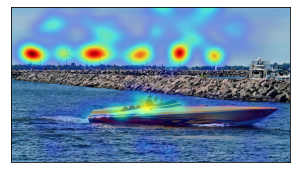

In [ ]:
# Gradcam visualisation
dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255
gradcam = samples['gradcams'].reshape(24,24)

avg_gradcam = getAttMap(norm_img, gradcam, blur=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(avg_gradcam)
ax.set_yticks([])
ax.set_xticks([])
print('Question: {}'.format(question))

#### 2. Image Captioning
Generate question-guided captions based on the relevancy score

In [ ]:
samples = model.forward_cap(samples=samples, num_captions=50, num_patches=20)
print('Examples of question-guided captions: ')
samples['captions'][0][:5]

Examples of question-guided captions: 


['a turbine turbine wind farm with a boat',
 'a orange and yellow speed boat moving around waves with wind farm in the background',
 'a speed boat with wind turbines in the background',
 'a man driving a motor wave boat behind wind turbine turbines',
 'a high speed boat speeding on a road']

#### 3. Question Generation
Generate synthetic questions using the captions

In [ ]:
samples = model.forward_qa_generation(samples)
print('Sample Question: {} \nSample Answer: {}'.format(samples['questions'][:5], samples['answers'][:5]))

Sample Question: ['what is in the background of the boat?', 'what is behind a boat in the background?', 'a turbine turbine wind farm with what?', 'what is in the background of the boat?', 'what is the boat moving around waves with wind turbines in the background?'] 
Sample Answer: ['wind.', 'turbines.', 'boat.', 'wind turbines.', 'speed.']


In [ ]:
samples['questions']

['what is in the background of the boat?',
 'what is behind a boat in the background?',
 'a turbine turbine wind farm with what?',
 'what is in the background of the boat?',
 'what is the boat moving around waves with wind turbines in the background?',
 'where is a speed boat with wind turbines in the background?',
 'what is in the background?',
 'in what part of the picture are wind turbines visible?',
 'where are the wind turbines?',
 'what type of boat is on a windy wind farm?',
 'who are on a speedboat as wind turbine farms reflect in the background?',
 'what is in the background of the boat?',
 'what type of wind farm is in the background?',
 'what is moving around waves with wind turbines in the background?',
 'what type of boat is being pulled beneath wind turbines?',
 'where are the wind turbines in the background?',
 'a turbine turbine wind farm with what?',
 'what is the wind turbine in the background?',
 'how is a high speed boat moving around waves?',
 'what type of boat is

#### 4. Prompt Construction
Prepare the prompts for LLM

In [ ]:
Img2Prompt = model.prompts_construction(samples)

#### 4. Load LLM and Predict Answers


In [ ]:
# In this notebook, we only use CPU for LLM inference
# To run inference on GPU, see https://github.com/CR-Gjx/Img2Prompt for reference
device = "cpu"

def postprocess_Answer(text):
    for i, ans in enumerate(text):
        for j, w in enumerate(ans):
            if w == '.' or w == '\n':
                ans = ans[:j].lower()
                break
    return ans

Img2Prompt_input = tokenizer(Img2Prompt, padding='longest', truncation=True, return_tensors="pt").to(device)

assert (len(Img2Prompt_input.input_ids[0])+20) <=2048

outputs_list  = []
outputs = llm_model.generate(input_ids=Img2Prompt_input.input_ids,
                         attention_mask=Img2Prompt_input.attention_mask,
                         max_length=20+len(Img2Prompt_input.input_ids[0]),
                         return_dict_in_generate=True,
                         output_scores=True
                         )
outputs_list.append(outputs)


#### 5. Decoding to answers

In [ ]:
outputs_list

pred_answer = tokenizer.batch_decode(outputs.sequences[:, len(Img2Prompt_input.input_ids[0]):])
pred_answer = postprocess_Answer(pred_answer)

print({"question": question, "answer": pred_answer})

{'question': 'what item s are spinning which can be used to control electric?', 'answer': 'wind turbines'}
